# Gen matching

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor

In [2]:
import json
selected = 'mXX-100_mA-0p25_lxy-300'
datasets = {selected: json.load(open('Samples/signal_4mu.json'))[selected]}

In [9]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "signal")
        match_axis = hist.Cat("match", "matched with darkphoton")
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", 50, 0, 100)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("norm. #counts/2GeV", dataset_axis, pt_axis, match_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        
        output['pt'].fill(dataset=dataset, pt=leptonjets[matchmask].pt.flatten(), match="true")
        output['pt'].fill(dataset=dataset, pt=leptonjets[~matchmask].pt.flatten(), match="false")
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [10]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=6, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5/5 [00:02<00:00,  2.49items/s]


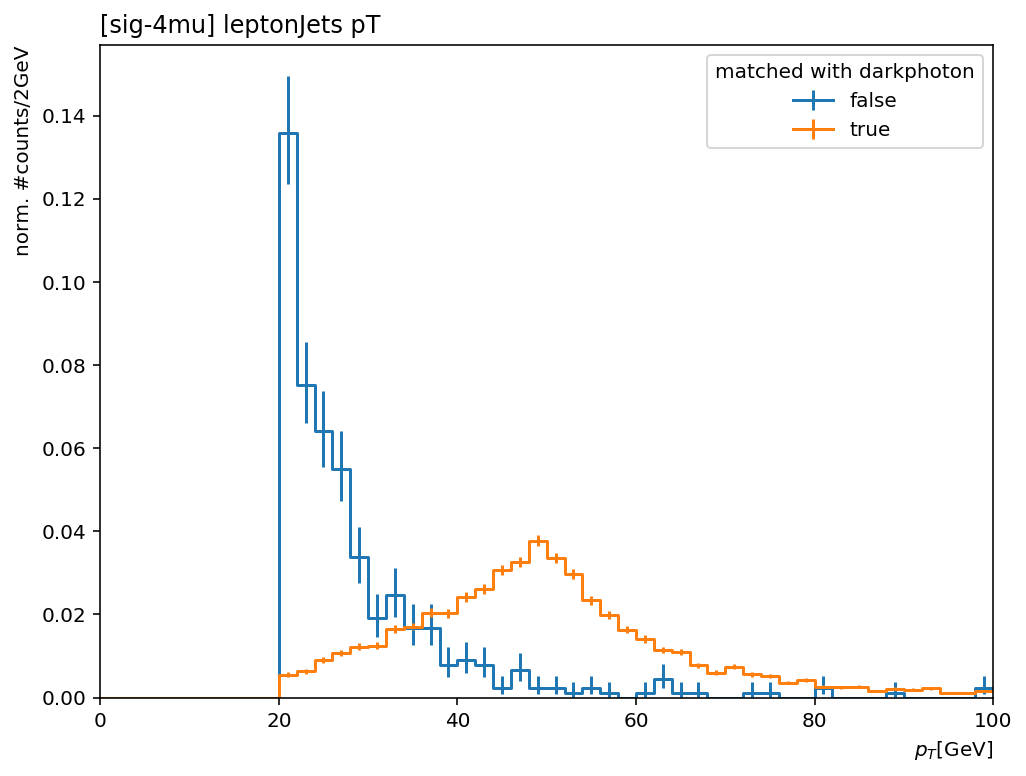

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['pt'].project('dataset'), ax=ax, overlay='match', density=True)

ax.set_title('[sig-4mu] leptonJets pT', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

---